### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(12, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "J"

In [7]:
df_J = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "J"].copy()
df_J

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
150,2021-02-15,INDO ISA,JL SEPAKU LAUT,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-06-10,Wiraswasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,JM0,J,INDIVIDU,35
414,2021-04-26,SENSILIA NONA ANITA,JL SOEKARNO HATTA KM 9,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1983-02-10,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,42
449,2021-05-05,ZULKHAIDIR,JL.WOLTER MONGINSIDI,BARU ULU,BALIKPAPAN BARAT,LAKI-LAKI,1975-08-03,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,49
576,2021-06-11,ABDUL RACHMAN,VILLA DAMAI PERMAI,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1967-05-13,Pegawai Swasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JM0,J,INDIVIDU,58
623,2021-06-25,PRESTIYONO,JL MULAWARMAN MANGGAR INDAH,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,1999-08-15,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JN0,J,INDIVIDU,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,2024-04-30,AHMAD EKSAN,BALIKPAPAN REGENCY,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1989-08-31,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMG,J,INDIVIDU,35
6176,2024-05-15,MOHAMMAD RISWAN,JL MAYOR POL ZAINAL ARIFIN,SUMBER REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1995-08-13,Pegawai Swasta-Pertambangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,JM1,J,INDIVIDU,29
6374,2024-06-12,WATI KASWATI,JL. GIRI REJO II,KARANG JOANG,BALIKPAPAN UTARA,PEREMPUAN,1985-12-21,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,JMH,J,INDIVIDU,39
6534,2024-07-16,SUGENG PRIYONO,JL PRONA III PERUM BUKIT PRONA INDAH,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1980-09-02,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,JS0,J,INDIVIDU,44


Plot data initial varian plus "J"

In [8]:
df_J_count = df_J[["Tgl. Mohon"]].copy()
df_J_count["count"] = 1.
df_J_count = df_J_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_J_count["cumulative_sum"] = df_J_count["count"].cumsum()
df_J_count["rolling_7days"] = df_J_count["count"].rolling(window=7, min_periods=1).sum()
df_J_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-02-15,1,1,1.0
1,2021-04-26,1,2,2.0
2,2021-05-05,1,3,3.0
3,2021-06-11,1,4,4.0
4,2021-06-25,1,5,5.0
...,...,...,...,...
75,2024-04-30,1,80,7.0
76,2024-05-15,1,81,7.0
77,2024-06-12,1,82,7.0
78,2024-07-16,1,83,7.0


Groub by weekly

In [9]:
df_J_weekly = df_J_count[["Tgl. Mohon"]].copy()
df_J_count["Tgl. Mohon"] = pd.to_datetime(df_J_count["Tgl. Mohon"])

df_J_weekly = (df_J.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_J_weekly["cumulative_sum"] = df_J_weekly["count"].cumsum()
df_J_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-02-15,1,1
1,2021-02-22,0,1
2,2021-03-01,0,1
3,2021-03-08,0,1
4,2021-03-15,0,1
...,...,...,...
181,2024-08-05,0,83
182,2024-08-12,0,83
183,2024-08-19,0,83
184,2024-08-26,0,83


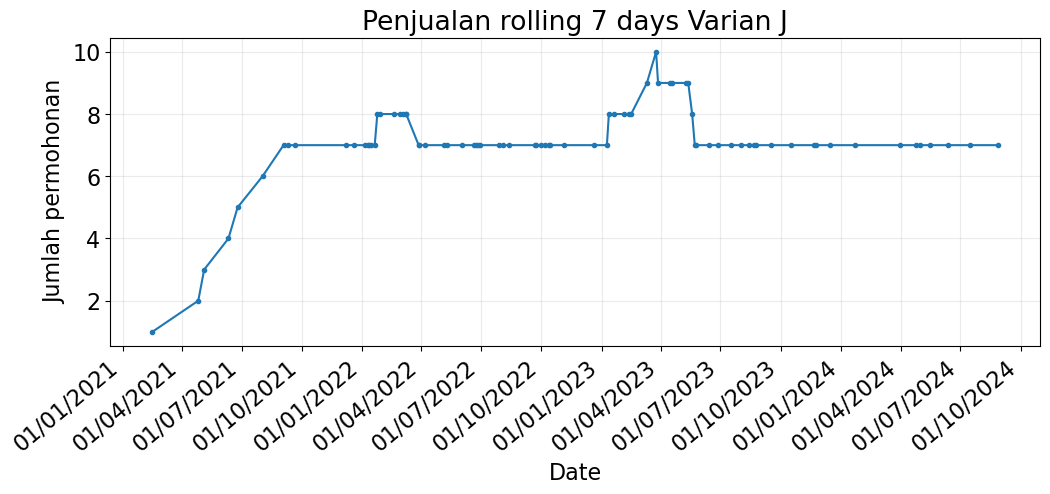

In [10]:
plot_time_series(df_J_count["Tgl. Mohon"], df_J_count["rolling_7days"], 
                title="Penjualan rolling 7 days Varian J",
                xlabel="Date", ylabel="Jumlah permohonan")

In [11]:
Q1 = df_J_count["rolling_7days"].quantile(0.25)
Q3 = df_J_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_J_count[(df_J_count["rolling_7days"] < batas_bawah) | 
                      (df_J_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian J: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian J: 26


,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-02-15,1,1,1.0
1,2021-04-26,1,2,2.0
2,2021-05-05,1,3,3.0
3,2021-06-11,1,4,4.0
4,2021-06-25,1,5,5.0
5,2021-08-02,1,6,6.0
16,2022-01-24,2,18,8.0
17,2022-01-28,1,19,8.0
18,2022-02-18,1,20,8.0
19,2022-02-28,1,21,8.0


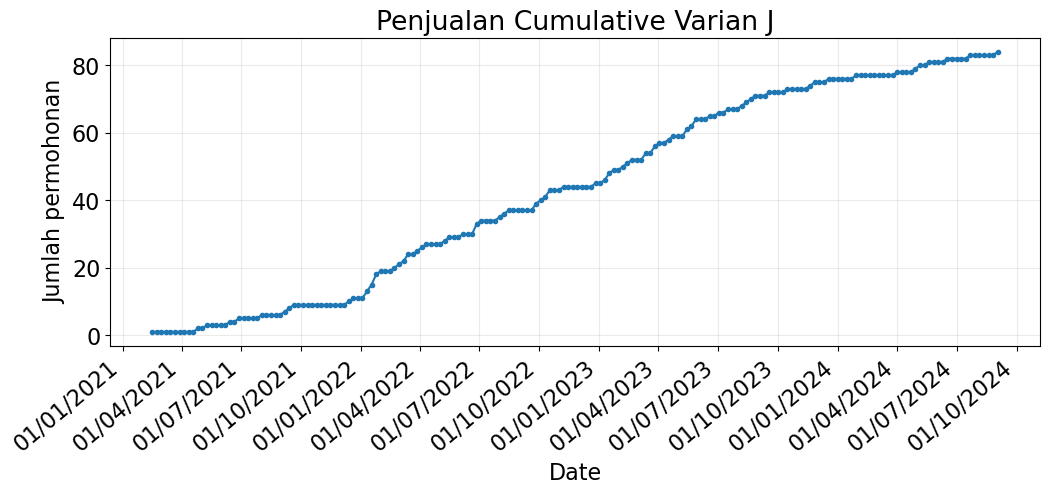

In [11]:
plot_time_series(df_J_weekly["Tgl. Mohon"], df_J_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian J",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [12]:
ADF_result = adfuller(df_J_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.49555796247661876
p-value: 0.8928804193839021


In [13]:
J_diff_week = np.diff(df_J_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(J_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -11.22805173397185
p-value: 1.9383015055654662e-20


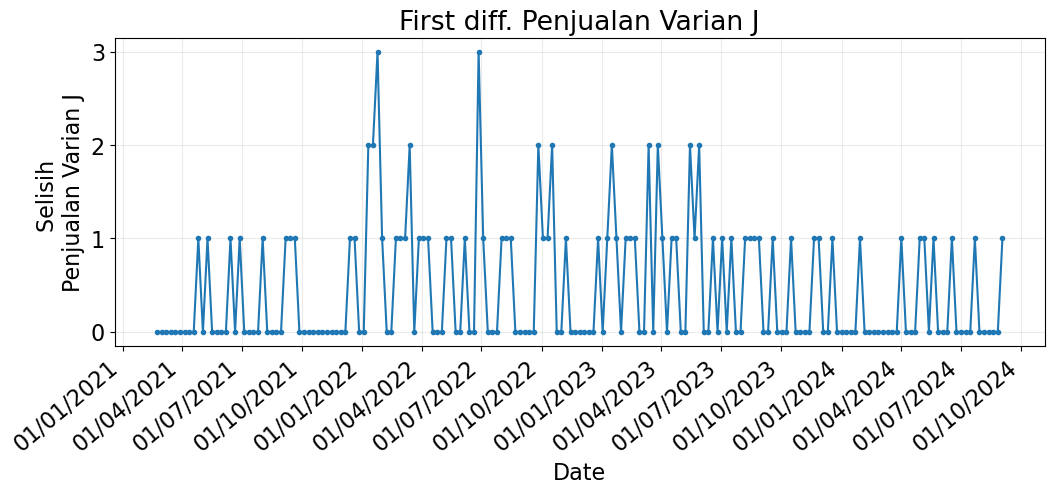

In [64]:
plot_time_series(df_J_weekly["Tgl. Mohon"].iloc[1:], J_diff_week, 
                 title="First diff. Penjualan Varian J",
                 xlabel="Date", ylabel="Selisih \nPenjualan Varian J")

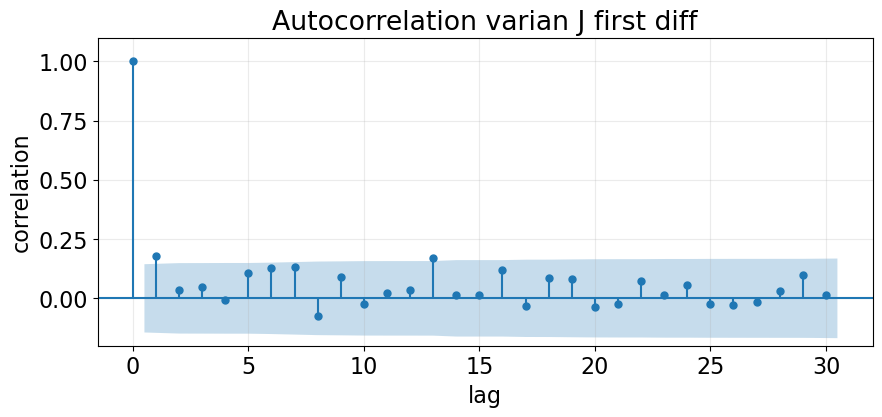

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(J_diff_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian J first diff")
ax.grid("on")

plt.show(fig)

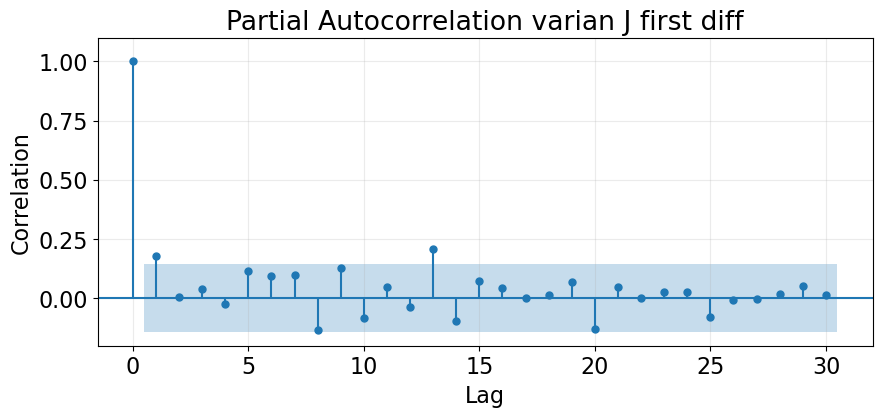

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(J_diff_week, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian J first diff")
ax.grid("on")

plt.show()

### harian

In [17]:
ADF_result = adfuller(df_J_count["rolling_7days"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.4289560923694267
p-value: 0.1337299716318805


fisrt diff (_d_=1)

In [18]:
J_diff = np.diff(df_J_count["rolling_7days"], n=1)
ADF_result = adfuller(J_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -4.854553508317296
p-value: 4.2719335679548044e-05


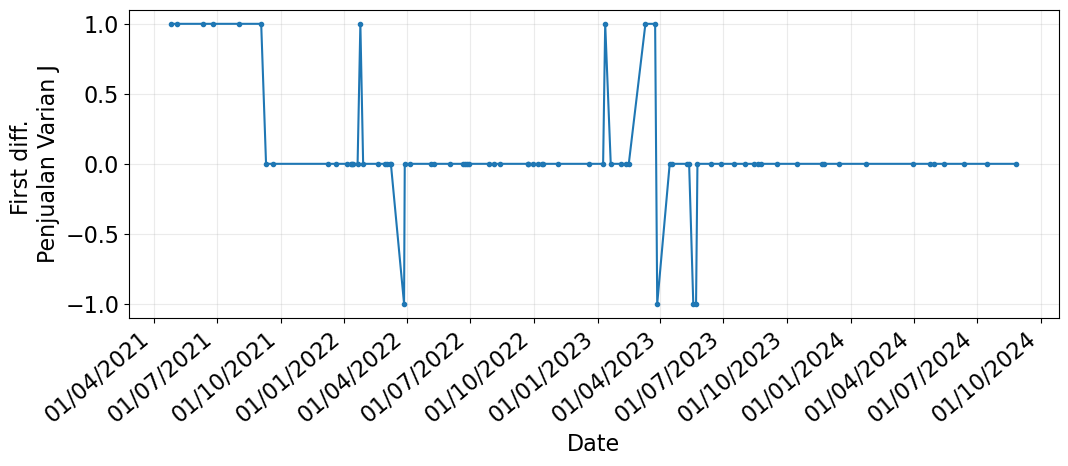

In [19]:
plot_time_series(df_J_count["Tgl. Mohon"].iloc[1:], J_diff, 
                #  title="First diff. Penjualan Varian J",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian J")

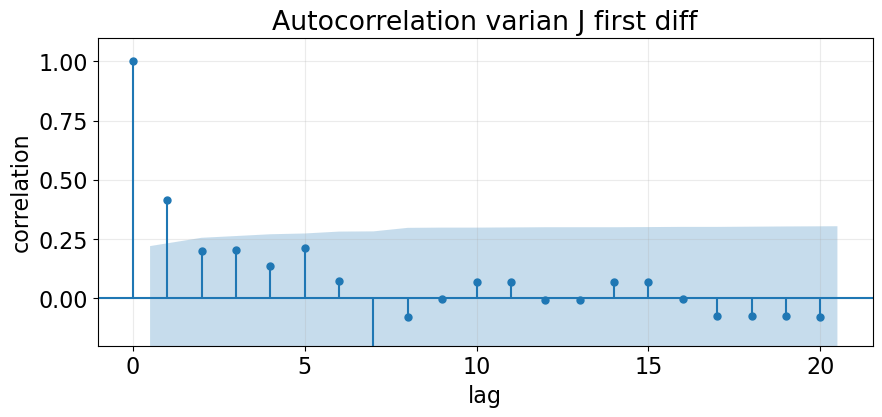

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(J_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian J first diff")
ax.grid("on")

plt.show(fig)

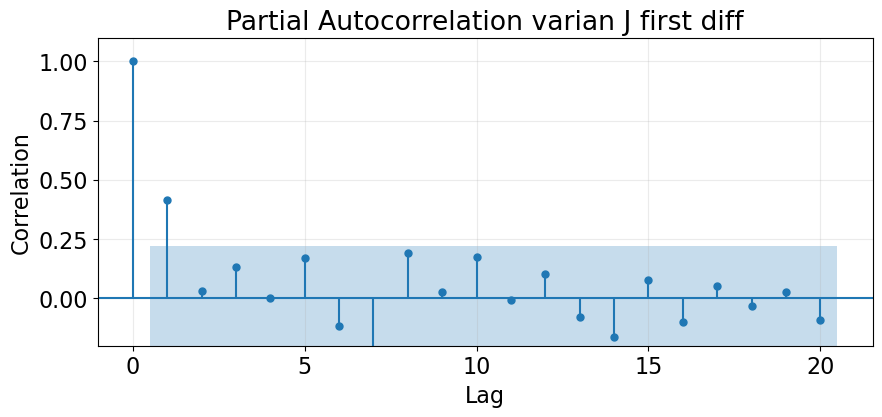

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(J_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian J first diff")
ax.grid("on")

plt.show()

AR(1)

### Data Splitting

In [22]:
df_J_diff = pd.DataFrame({
    "Tgl. Mohon": df_J_count["Tgl. Mohon"].iloc[1:],
    "J_diff": J_diff})

split_idx = int(0.8 * len(df_J_diff))
df_train = df_J_diff.iloc[:split_idx].copy()
df_test = df_J_diff.iloc[split_idx:].copy()


print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (63, 16)


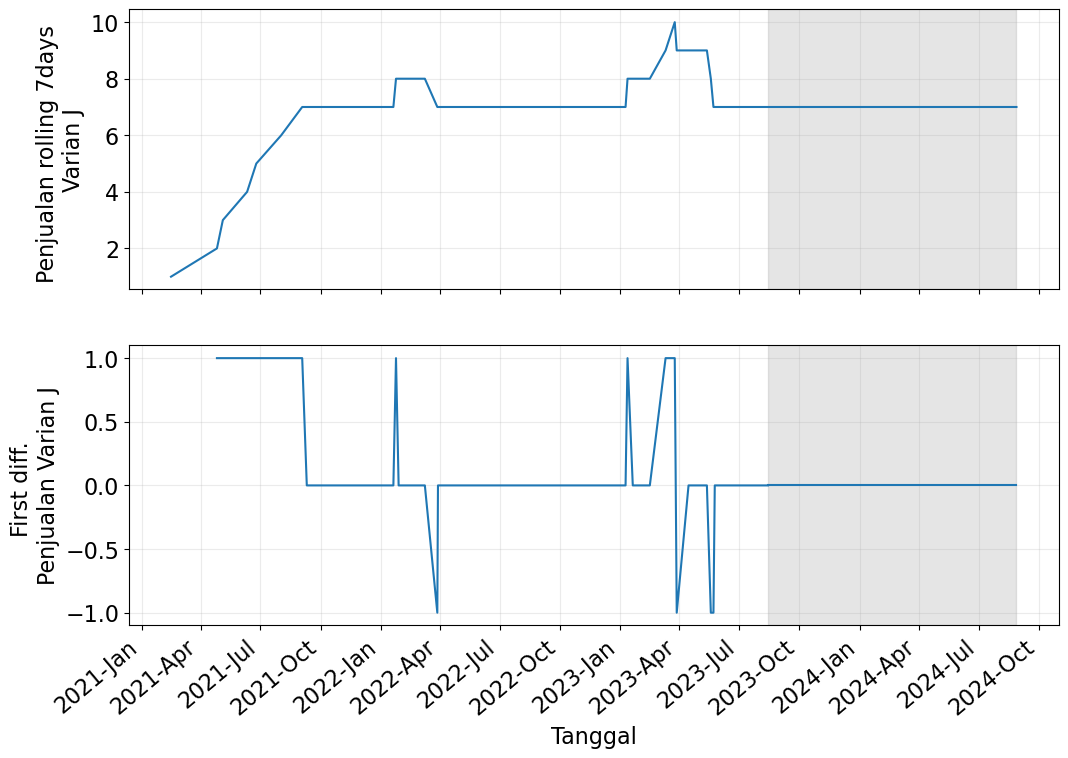

In [23]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# -- first row
axes[0].plot(df_J_count["Tgl. Mohon"], df_J_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian J")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["J_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["J_diff"], color="tab:blue")
axes[1].set_xlabel("Tanggal")
axes[1].set_ylabel("First diff. \nPenjualan Varian J")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA (1) AR(1)

In [24]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["J_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["J_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["J_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["J_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["J_diff"], order=(1, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR

In [25]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 4

pred_mean = rolling_forecast(df_J_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_J_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_J_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")
pred_AR = rolling_forecast(df_J_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA
pred_df["pred_AR"] = pred_AR

pred_df

,Tgl. Mohon,J_diff,pred_mean,pred_last_value,pred_MA,pred_AR
64,2023-08-14,0.0,0.095238,0.0,2.947768e-03,-4.118290e-86
65,2023-08-21,0.0,0.095238,0.0,0.000000e+00,-1.868500e-86
66,2023-08-25,0.0,0.095238,0.0,0.000000e+00,-8.477533e-87
67,2023-09-16,0.0,0.095238,0.0,0.000000e+00,-3.846323e-87
68,2023-10-16,0.0,0.089552,0.0,8.652359e-05,-1.536891e-150
69,2023-11-20,0.0,0.089552,0.0,0.000000e+00,-6.980010e-151
70,2023-11-24,0.0,0.089552,0.0,0.000000e+00,-3.170072e-151
71,2023-12-15,0.0,0.089552,0.0,0.000000e+00,-1.439734e-151
72,2024-01-23,0.0,0.084507,0.0,2.554105e-06,-5.488696e-217
73,2024-03-31,0.0,0.084507,0.0,0.000000e+00,-2.495000e-217


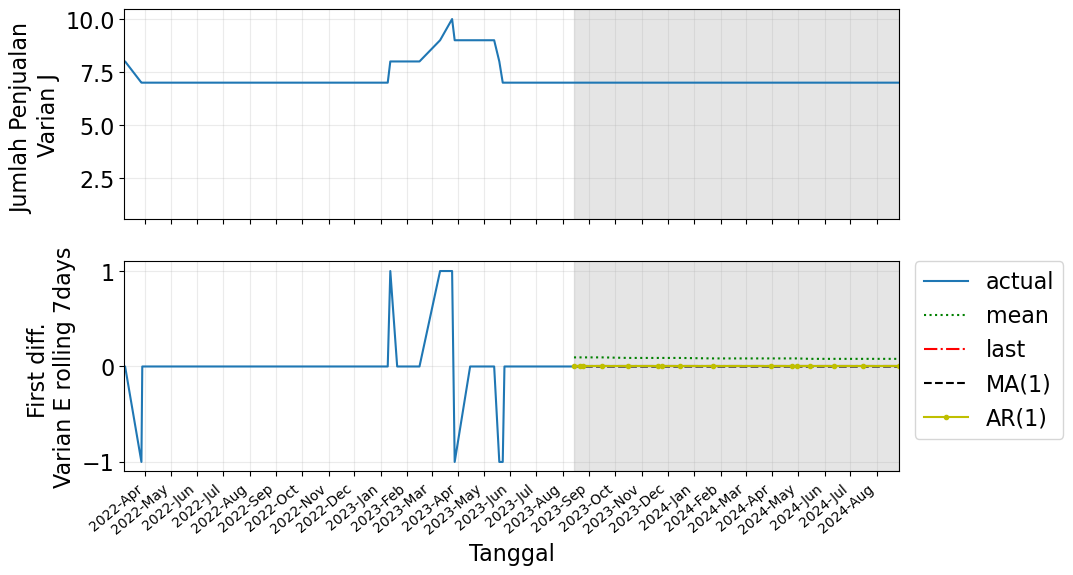

In [26]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 20  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["J_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["J_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Tanggal")
axes[1].set_ylabel("First diff. \nVarian E rolling 7days")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_J_count['Tgl. Mohon'], df_J_count["rolling_7days"])

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Penjualan \nVarian J")
axes[0].set_xlim(xlim)


plt.show(fig)

In [27]:
mse_mean = mean_squared_error(pred_df["J_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["J_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["J_diff"], pred_df["pred_MA"])
mse_AR = mean_squared_error(pred_df["J_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")
print(f"MSE AR: {mse_AR}")

MSE mean: 0.007657834612545102
MSE last: 0.0
MSE MA: 5.435518205405963e-07
MSE AR: 1.332389460660298e-172


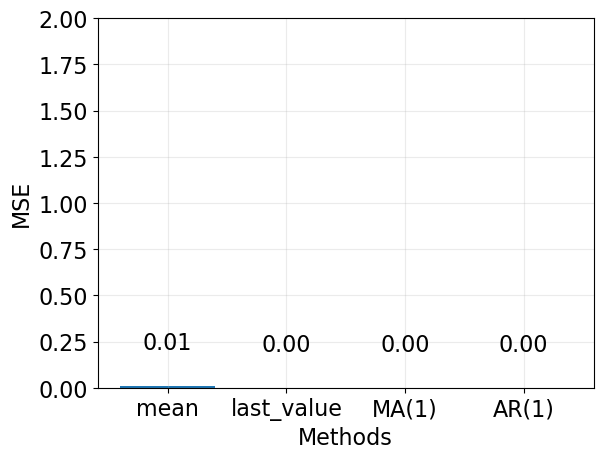

In [28]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean, mse_last, mse_MA, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 2])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [29]:
idx_y0 = len(df_train) + 1 
y0 = df_J_count.iloc[idx_y0]["rolling_7days"]
# print(y0)
df_test_J = df_J_count[idx_y0:].copy()
df_test_J["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_J["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_J["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_J["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
df_test_J.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_last_value,pred_MA,pred_AR
64,2023-08-14,1,69,7.0,7.095238,7.0,7.002948,7.0
65,2023-08-21,1,70,7.0,7.190476,7.0,7.002948,7.0
66,2023-08-25,1,71,7.0,7.285714,7.0,7.002948,7.0
67,2023-09-16,1,72,7.0,7.380952,7.0,7.002948,7.0
68,2023-10-16,1,73,7.0,7.470505,7.0,7.003034,7.0


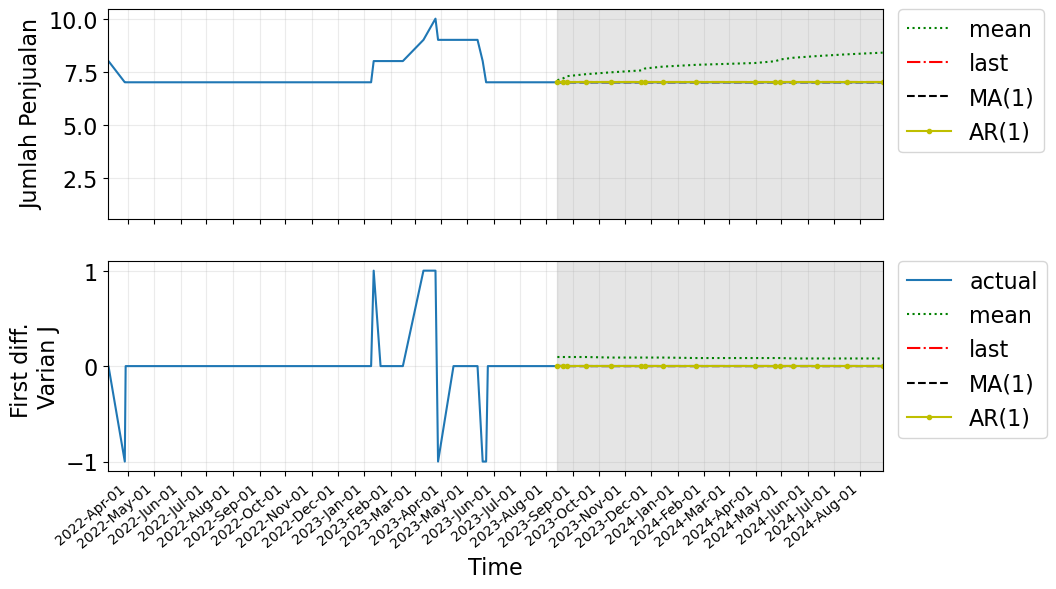

In [30]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 20  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["J_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["J_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian J")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_J_count['Tgl. Mohon'], df_J_count["rolling_7days"])

# -- prediction for the original data
axes[0].plot(df_test_J['Tgl. Mohon'], df_test_J["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_J['Tgl. Mohon'], df_test_J["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_J['Tgl. Mohon'], df_test_J["pred_MA"], "k--", label="MA(1)")
axes[0].plot(df_test_J['Tgl. Mohon'], df_test_J["pred_AR"], "y.-", label="AR(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Penjualan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1) AR(1)

MAE

In [31]:
mae_mean_undiff = mean_absolute_error(df_test_J["rolling_7days"], df_test_J["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_J["rolling_7days"], df_test_J["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_J["rolling_7days"], df_test_J["pred_MA"])
mae_AR_undiff   = mean_absolute_error(df_test_J["rolling_7days"], df_test_J["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 0.767636665765739
MAE last: 0.0
MAE MA: 0.003013956699684739
MAE AR: 0.0


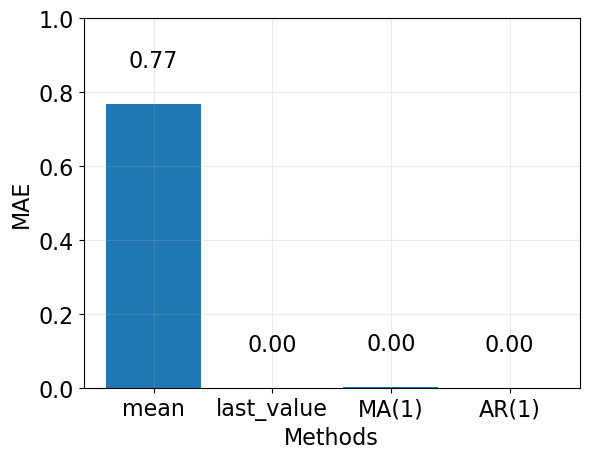

In [32]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [33]:
mse_mean_undiff = mean_squared_error(df_test_J["rolling_7days"], df_test_J["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_J["rolling_7days"], df_test_J["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_J["rolling_7days"], df_test_J["pred_MA"])
mse_AR_undiff   = mean_squared_error(df_test_J["rolling_7days"], df_test_J["pred_AR"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")
print(f"MSE AR: {mse_AR_undiff}")

MSE mean: 0.7488324130754287
MSE last: 0.0
MSE MA: 9.08539642203475e-06
MSE AR: 0.0


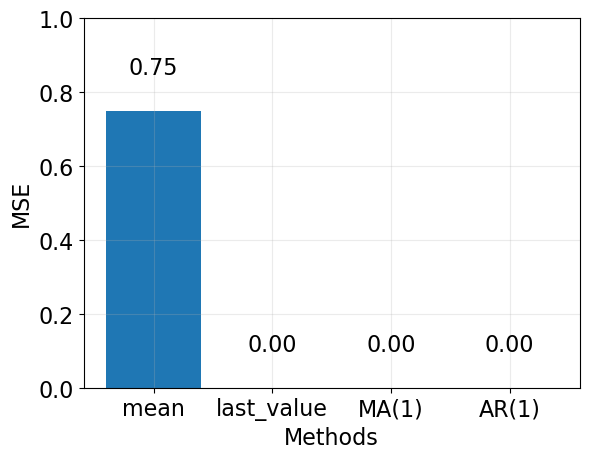

In [34]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff, mse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [35]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)
rmse_AR_undiff = np.sqrt(mse_AR_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")
print(f"RMSE AR: {rmse_AR_undiff}")

RMSE mean: 0.8653510345954575
RMSE last: 0.0
RMSE MA: 0.003014199134436003
RMSE AR: 0.0


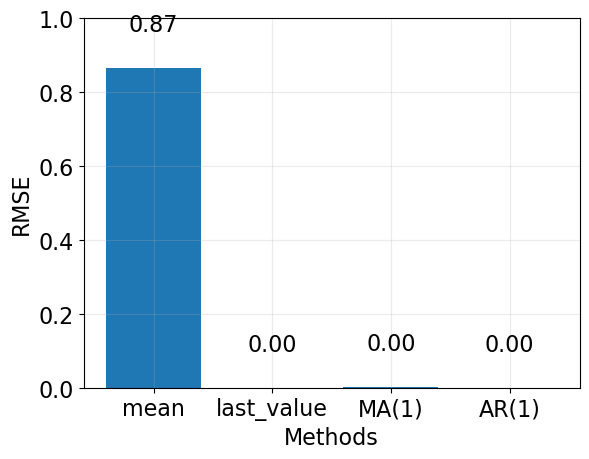

In [36]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff, rmse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [37]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_J["rolling_7days"], df_test_J["pred_mean"]) * 100
mape_last_undiff = mean_absolute_percentage_error(df_test_J["rolling_7days"], df_test_J["pred_last_value"]) * 100
mape_MA_undiff   = mean_absolute_percentage_error(df_test_J["rolling_7days"], df_test_J["pred_MA"]) * 100
mape_AR_undiff   = mean_absolute_percentage_error(df_test_J["rolling_7days"], df_test_J["pred_AR"]) * 100

print(f"MAPE mean: {mape_mean_undiff:.2f}%")
print(f"MAPE last: {mape_last_undiff:.2f}%")
print(f"MAPE MA: {mape_MA_undiff:.2f}%")
print(f"MAPE AR: {mape_AR_undiff:.2f}%")

MAPE mean: 10.97%
MAPE last: 0.00%
MAPE MA: 0.04%
MAPE AR: 0.00%


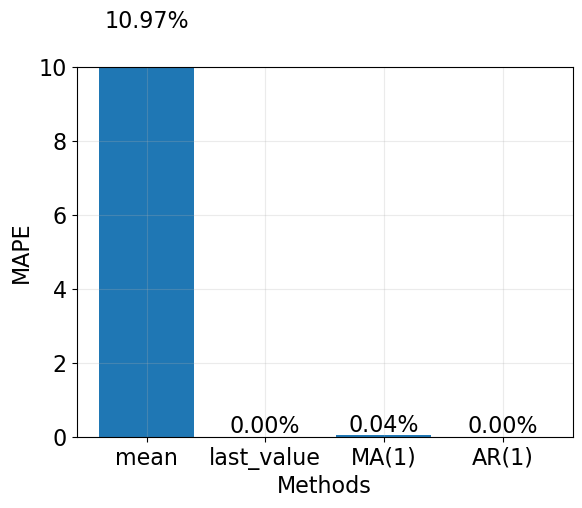

In [38]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff, mape_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 10])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [39]:
naive = np.abs(np.diff(df_test_J["rolling_7days"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive
mase_AR_undiff   = mae_AR_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")
print(f"MASE AR: {mase_AR_undiff}")

MASE mean: inf
MASE last: nan
MASE MA: inf
MASE AR: nan


C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\1833777919.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  mase_mean_undiff = mae_mean_undiff / naive
C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\1833777919.py:4: RuntimeWarning: invalid value encountered in scalar divide
  mase_last_undiff = mae_last_undiff / naive
C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\1833777919.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  mase_MA_undiff   = mae_MA_undiff / naive
C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\1833777919.py:6: RuntimeWarning: invalid value encountered in scalar divide
  mase_AR_undiff   = mae_AR_undiff / naive


C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\1475150058.py:10: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, 0])
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


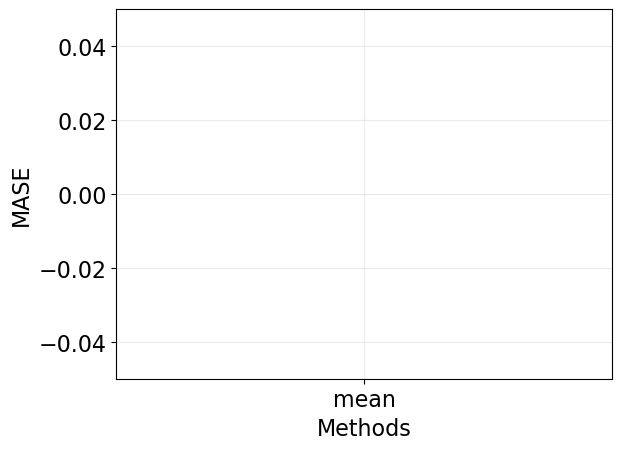

In [40]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff, mase_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 0])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting ARIMA

In [41]:
split_idx = int(0.8 * len(df_J_count))
df_train_arima = df_J_count.iloc[:split_idx].copy()
df_test_arima = df_J_count.iloc[split_idx:].copy()

print(f"(len(df_train_arima), len(df_test_arima)): {len(df_train_arima), len(df_test_arima)}")


(len(df_train_arima), len(df_test_arima)): (64, 16)


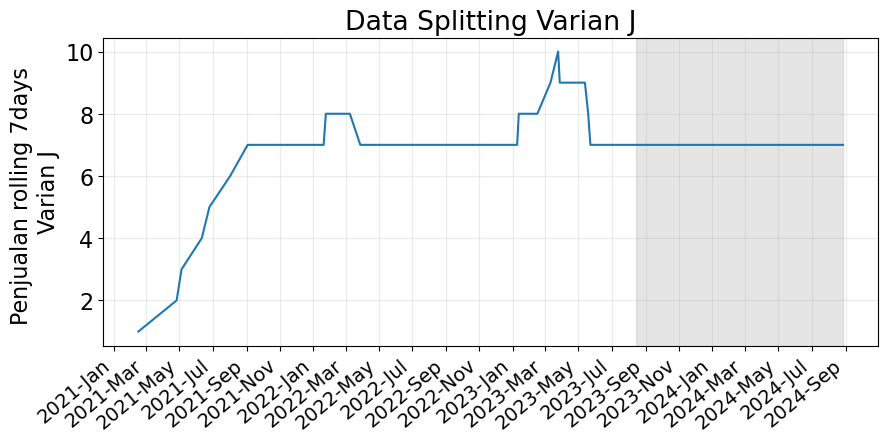

In [67]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_J_count['Tgl. Mohon'], df_J_count["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan rolling 7days \nVarian J")
ax.set_title("Data Splitting Varian J")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (2,1,1)

In [43]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [44]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [45]:
result_df = optimize_ARIMA(df_train_arima["rolling_7days"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2)
(2, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0)
(3, 1)
(3, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(2, 3)",70.898067
1,"(3, 3)",73.448345
2,"(1, 0)",74.379130
3,"(1, 1)",75.296432
4,"(2, 0)",76.126501
5,"(3, 0)",76.225491
6,"(1, 2)",76.282772
7,"(0, 1)",76.420382
8,"(2, 1)",76.685322
9,"(1, 3)",76.881854


In [46]:
best_p, best_q = (2, 3)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (2, 3)


In [47]:
model_arima_best = SARIMAX(df_train_arima["rolling_7days"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


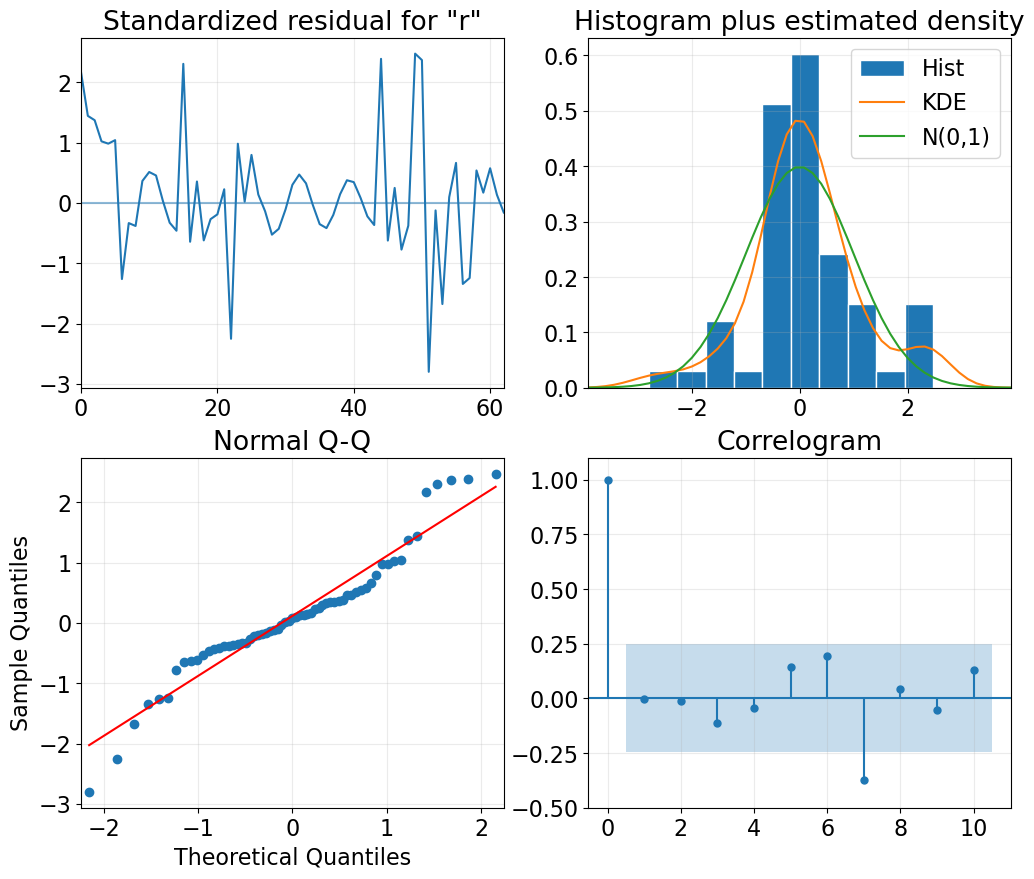

In [48]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [49]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.833568,0.361243
2,1.132882,0.567542
3,1.225664,0.746856
4,1.228432,0.873396
5,3.089224,0.686232
6,5.842711,0.441039
7,16.175545,0.023560
8,16.218637,0.039356
9,16.514641,0.056882
10,17.791889,0.058577


_p-value_ > 0.05 untuk semua lag, maka tidak ada autokorelasi dalam residual. Artiinya model menangkap semua pola dalam data

In [50]:
df_test_pred_arima = df_test_arima.copy()

TRAIN_LEN = len(df_train_arima)
HORIZON = len(df_test_arima)

pred_mean = np.ones(HORIZON)*np.mean(df_train_arima["rolling_7days"])
pred_naive_seasonal = df_train_arima["rolling_7days"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred_arima["pred_mean"] = pred_mean
df_test_pred_arima["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred_arima["pred_arima"] = pred_arima

df_test_pred_arima.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_naive_seasonal,pred_arima
64,2023-08-14,1,69,7.0,7.109375,8.0,7.169215
65,2023-08-21,1,70,7.0,7.109375,8.0,7.348033
66,2023-08-25,1,71,7.0,7.109375,9.0,7.418491
67,2023-09-16,1,72,7.0,7.109375,10.0,7.402847
68,2023-10-16,1,73,7.0,7.109375,9.0,7.352229


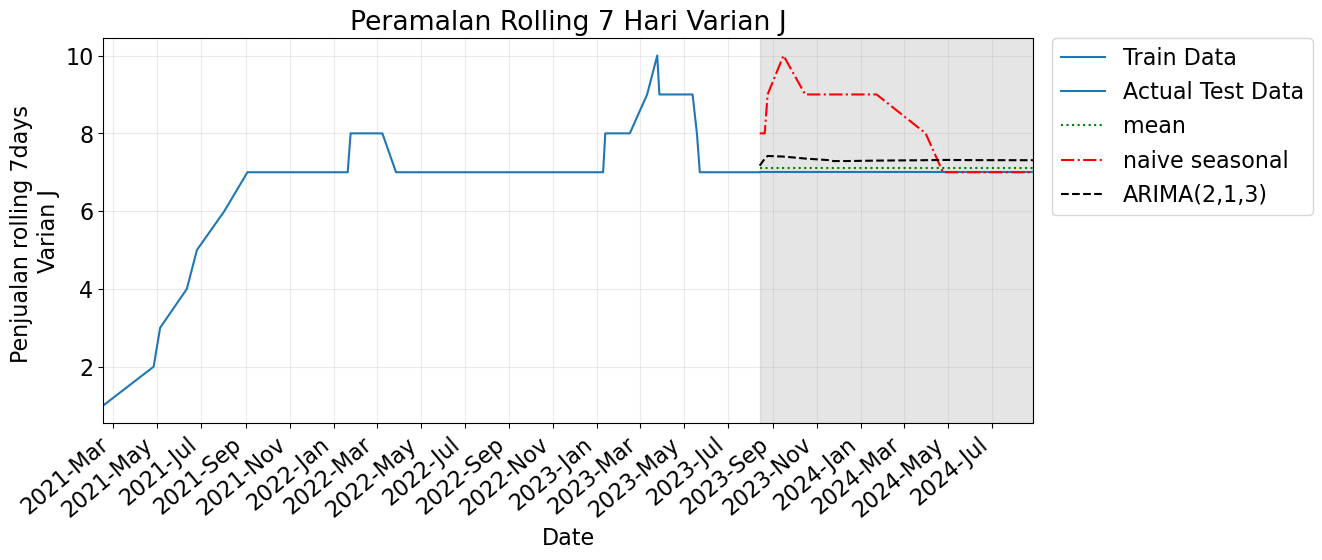

In [76]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 0  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian J")
ax.set_title("Peramalan Rolling 7 Hari Varian J")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--",
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

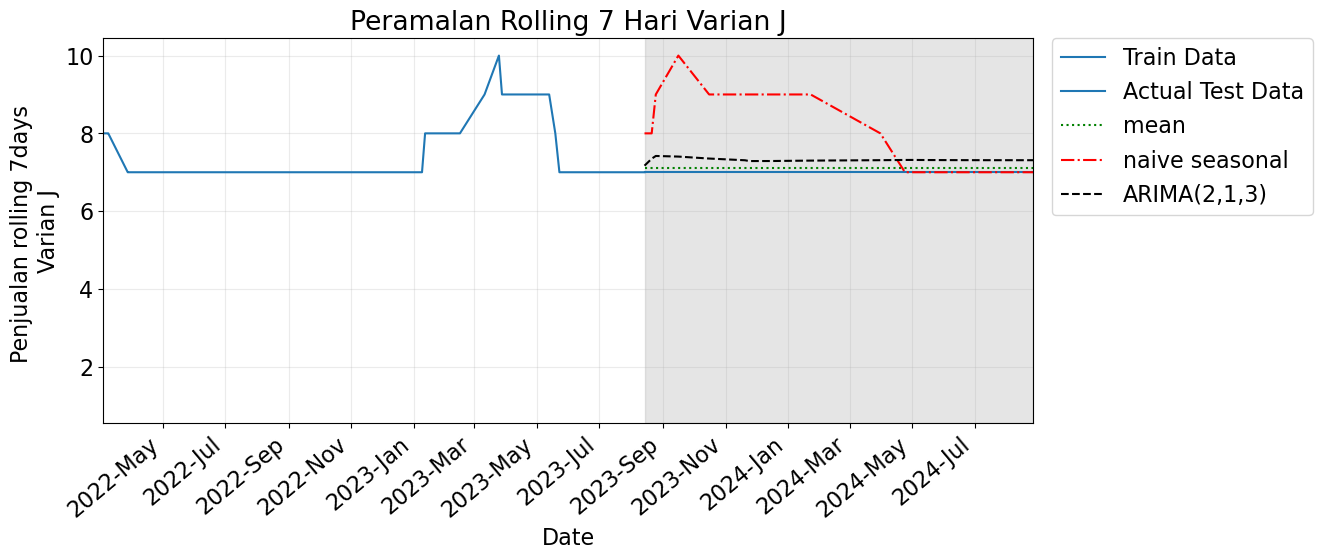

In [79]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 20  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian J")
ax.set_title("Peramalan Rolling 7 Hari Varian J")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

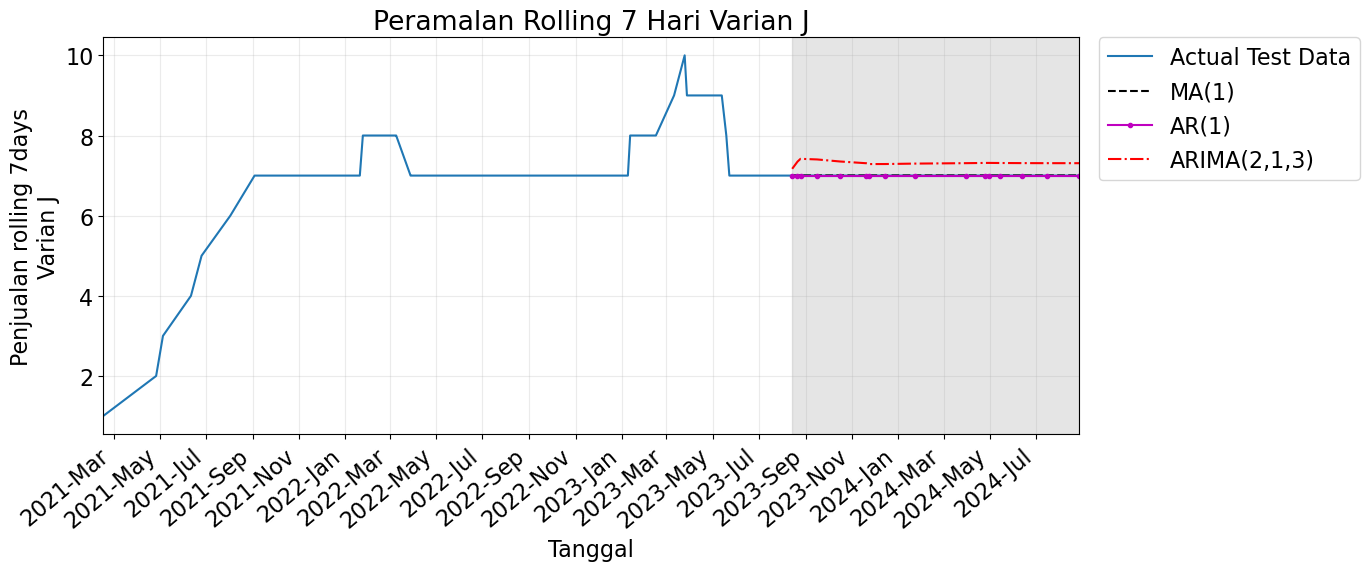

In [80]:
# Gabungkan training cumulative + satu data awal dari test untuk continuity
df_train_cum_extended = pd.concat([df_J_count, df_test_J.iloc[:1]])

start_idx = 0  # Untuk visualisasi lebih fokus
xlim = [df_J_count["Tgl. Mohon"].iloc[start_idx], df_test_J["Tgl. Mohon"].iloc[-1]]

# Mulai plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot data aktual cumulative
ax.plot(df_J_count["Tgl. Mohon"], df_J_count["rolling_7days"])
ax.plot(df_test_J["Tgl. Mohon"], df_test_J["rolling_7days"], label="Actual Test Data", color="tab:blue")

# Plot prediksi MA dan AR untuk cumulative
ax.plot(df_test_J["Tgl. Mohon"], df_test_J["pred_MA"], "k--", label="MA(1)")
ax.plot(df_test_J["Tgl. Mohon"], df_test_J["pred_AR"], "m.-", label="AR(1)")

# Plot prediksi ARIMA
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "r-.", label=f"ARIMA({best_p},{d},{best_q})")

# Forecast area
ax.axvspan(df_test_J['Tgl. Mohon'].iloc[0], df_test_J['Tgl. Mohon'].iloc[-1], color="#808080", alpha=0.2)

# Formatting tanggal di x-axis
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# Pengaturan tambahan
ax.set_xlim(xlim)
ax.grid(True)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan rolling 7days\nVarian J")
ax.set_title("Peramalan Rolling 7 Hari Varian J")
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# Rotate x-tick labels
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


### Evaluasi ARIMA (2,1,1)

MAE

In [54]:
mae_mean           = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 0.109375
MAE naive seasonal: 1.125
MAE ARIMA: 0.3163405916420086


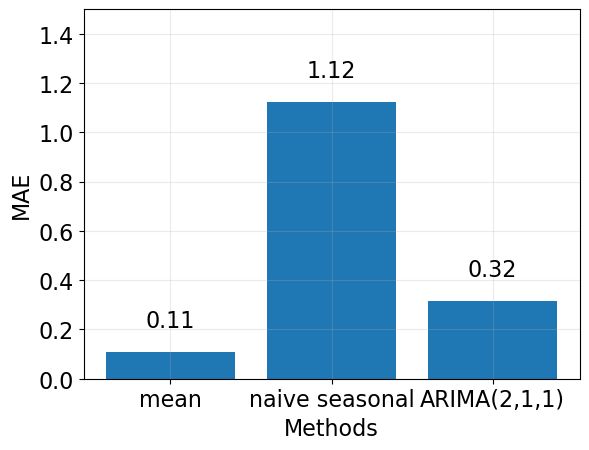

In [55]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 1.5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [56]:
mse_mean           = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mse_arima          = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 0.011962890625
MSE naive seasonal: 2.25
MSE ARIMA: 0.10281901995733966


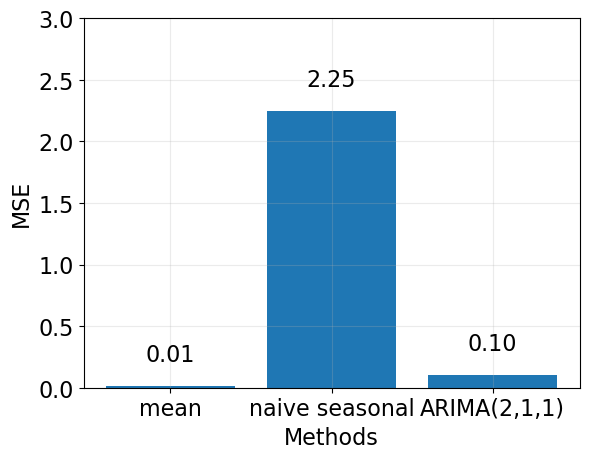

In [57]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 3])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [58]:
rmse_mean           = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE arima: {rmse_arima }")

RMSE mean: 0.109375
RMSE naive seasonal: 1.5
RMSE arima: 0.3206540502743411


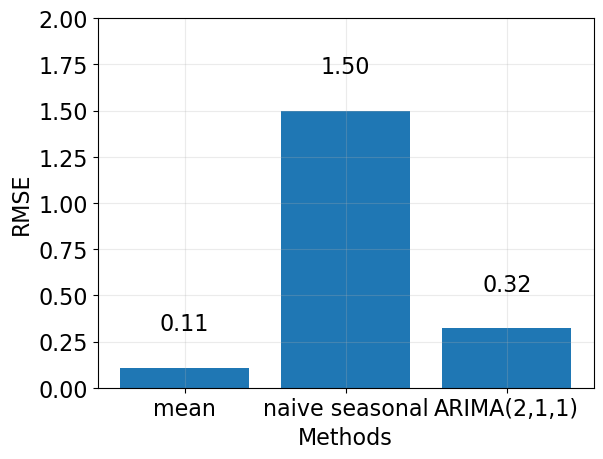

In [59]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 2])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [60]:
mape_mean           = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_mean"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_naive_seasonal"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_arima          = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_arima"]) / df_test_pred_arima["rolling_7days"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 1.56%
MAPE naive seasonal: 16.07%
MAPE ARIMA: 4.52%


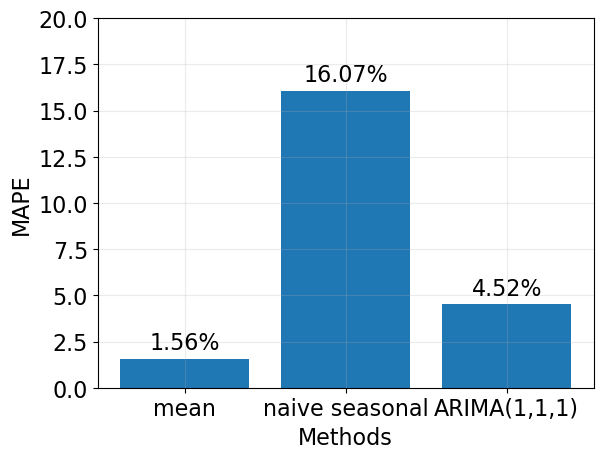

In [61]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [62]:
naive = np.abs(np.diff(df_test_pred_arima["rolling_7days"])).mean()

mase_mean           = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima          = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: inf
MASE naive seasonal: inf
MASE ARIMA: inf


C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\3415919081.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  mase_mean           = mae_mean_undiff / naive
C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\3415919081.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mase_naive_seasonal = mae_naive_seasonal / naive
C:\Users\TEMP\AppData\Local\Temp\ipykernel_1164\3415919081.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  mase_arima          = mae_arima / naive


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


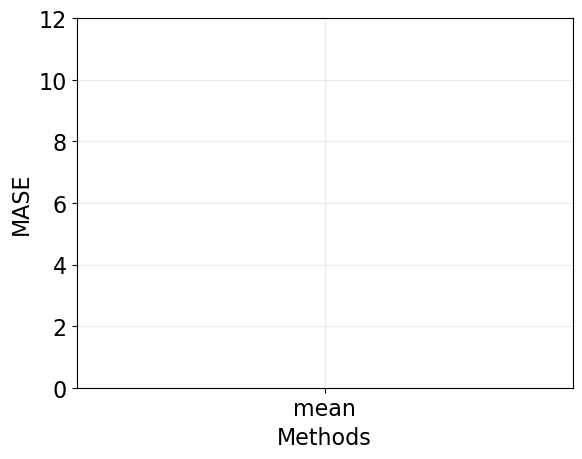

In [63]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 12])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)